In [41]:
import tensorflow as tf
from tensorflow.keras.layers import Dense,Conv2D,Input,Dropout,ZeroPadding2D,BatchNormalization,Flatten,Activation,MaxPooling2D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.callbacks import TensorBoard,ModelCheckpoint
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import time
from os import listdir
%matplotlib inline

In [11]:
def resize(img,plot=False):
  gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
  gray=cv2.GaussianBlur(gray,(5,5),0)
  thresh=cv2.threshold(gray,45,255,cv2.THRESH_BINARY)[1]
  thresh=cv2.erode(thresh,None,iterations=2)
  thresh=cv2.dilate(thresh,None,iterations=2)
  cnt=cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
  cnt=imutils.grab_contours(cnt)
  c=max(cnt,key=cv2.contourArea)
  exleft=tuple(c[c[:,:,0].argmin()][0])
  exright=tuple(c[c[:,:,0].argmax()][0])
  extop=tuple(c[c[:,:,1].argmin()][0])
  exbottom=tuple(c[c[:,:,1].argmax()][0])
  newimg=img[extop[1]:exbottom[1],exleft[0]:exright[0]]

  if plot:
    plt.figure()
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
    plt.title('img')
    plt.subplot(1,2,2)
    plt.imshow(newimg)
    plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

    plt.title('cropped img')
    plt.show()
  return newimg



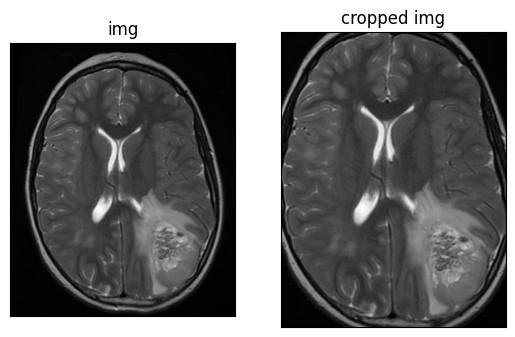

In [12]:
example=cv2.imread('/content/drive/MyDrive/Brain/Yes/Y100.JPG')
examplenew=resize(example,True)

In [13]:
def data(dir_list, imgsize):
  X=[]
  y=[]
  imgwidth,imgheight=imgsize
  for directory in dir_list:
        for filename in listdir(directory):
           
            image = cv2.imread(directory + filename)
            

            if image is None:
              continue
            
            image = resize(image, plot=False)
           
            image = cv2.resize(image, dsize=(imgwidth, imgheight), interpolation=cv2.INTER_CUBIC)
            
            image = image / 255.
           
            X.append(image)
          
            if directory[-3:] == 'Yes':
                y.append([1])
            else:
                y.append([0])

  X = np.array(X)
  y = np.array(y)



  print(f'Number of examples is: {len(X)}')
  print(f'X shape is: {X.shape}')
  print(f'y shape is: {y.shape}')

  return X, y

yes = '/content/drive/MyDrive/newbrain/Yes/'
no = '/content/drive/MyDrive/newbrain/No/'

imgwidth,imgheight = (240, 240)

X, y = data([yes, no], (imgwidth,imgheight))

Number of examples is: 890
X shape is: (890, 240, 240, 3)
y shape is: (890, 1)


In [27]:
def splitdata(X,y,test_size=0.2):
  X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
  X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.4)

  return X_train, y_train, X_val, y_val, X_test, y_test

In [28]:
X_train, y_train, X_val, y_val, X_test, y_test = splitdata(X, y, test_size=0.4)

In [29]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 534
number of development examples = 143
number of test examples = 213
X_train shape: (534, 240, 240, 3)
Y_train shape: (534, 1)
X_val (dev) shape: (143, 240, 240, 3)
Y_val (dev) shape: (143, 1)
X_test shape: (213, 240, 240, 3)
Y_test shape: (213, 1)


In [30]:
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return f"{h}:{m}:{round(s,1)}"

In [18]:
def compute_f1_score(y_true, prob):
   
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

In [71]:
def modelling(inpshape):
  X_input=Input(inpshape)

  X=Conv2D(32,(7,7),strides=(1,1),name='conv0')(X_input)
  X = BatchNormalization(axis = 3, name = 'bn0')(X)
  X=Activation('relu')(X)
  X=MaxPooling2D((4,4),name='max_pool0')(X)

  X=Flatten()(X)
  X = Dense(128, activation='relu', name='fc')(X)  
  X = Dropout(0.7)(X)

  X=Dense(1,activation='sigmoid')(X)
  model=Model(inputs=X_input,outputs=X,name='BrainTumorModel')
  return model





In [74]:
imgshape=(imgwidth,imgheight,3)
model=modelling(imgshape)
newmodel1=modelling(imgshape)
newmodel1.set_weights(model.get_weights())
newmodel1.summary()

Model: "BrainTumorModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 240, 240, 3)]     0         
                                                                 
 conv0 (Conv2D)              (None, 234, 234, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 234, 234, 32)      128       
                                                                 
 activation_21 (Activation)  (None, 234, 234, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 58, 58, 32)        0         
                                                                 
 flatten_21 (Flatten)        (None, 107648)            0         
                                                                 
 fc (Dense)                  (None, 128)           

In [75]:
checkpoint = ModelCheckpoint('model-{epoch:03d}-{acc:03f}-{val_acc:03f}.h5',
    verbose=1,
    monitor='val_loss',
    save_best_only=True,
    mode='auto'
)

newmodel1.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
newmodel1.fit(x=X_train,y=y_train,batch_size=32,epochs=5,validation_data=(X_val,y_val))


Epoch 1/5
17/17 [==============================] - 58s 3s/step - loss: 0.0771 - accuracy: 0.9663 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/5
17/17 [==============================] - 67s 4s/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/5
 9/17 [==============>...............] - ETA: 32s - loss: 0.0000e+00 - accuracy: 1.0000

KeyboardInterrupt: 

In [101]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input
import numpy as np


img_path = '/content/br.jpeg'
img = image.load_img(img_path, target_size=(240, 240))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
predictions = model.predict(img_array)
threshold = 0.5
if predictions[0, 0] > threshold:
    print("Class 1 (no)")
else:
    print("Class 0 (yes)")


1/1 [==============================] - 0s 46ms/step
Class 1 (no)


In [ ]:
model.save('brain.keras')

In [ ]:
new_model = tf.keras.models.load_model('brain.keras')

In [ ]:
new_model.summary()

Model: "BrainTumorModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d_3 (ZeroPadd  (None, 244, 244, 3)       0         
 ing2D)                                                          
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 activation_3 (Activation)   (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                                                 
 flatten_3 (Flatten)         (None, 111392)            0         
                                                   

In [ ]:
!mkdir -p saved_model
model.save('saved_model/my_model')

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [9]:
orgdir='/content/drive/MyDrive/Brain/No/'
savdir='/content/drive/MyDrive/newbrain/No/'
os.makedirs(savdir,exist_ok=True)
datagen=ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

for filename in os.listdir(orgdir):
  if filename.endswith(('.jpg','.jpeg','.png')):

     orgpath=os.path.join(orgdir,filename)
     orgimg=Image.open(orgpath)
     orgimg= orgimg.convert('RGB')
     imgarr=tf.keras.preprocessing.image.img_to_array(orgimg)
     imgarr=imgarr.reshape((1,)+imgarr.shape)

     augimg=[]
     numberofimg=5
     for batch in datagen.flow(imgarr,batch_size=1):
      augimg.append(batch[0])
      if len(augimg)>=numberofimg:
        break
     for i ,augimg in enumerate(augimg):
      augfilename=f'{os.path.splitext(filename)[0]}_aug_{i+1}.jpg'
      augimgpath=os.path.join(savdir,augfilename)
      augimgpil=tf.keras.preprocessing.image.array_to_img(augimg)
      augimgpil.save(augimgpath)
print("completed")






completed
